In [1]:
import sys
sys.path.append('/app')
from src.climate_learn import LitModule
from src.climate_learn import download_weatherbench
from src.climate_learn import convert_nc2npz
from src.climate_learn import IterDataModule
from src.climate_learn.utils import visualize_at_index, visualize_mean_bias
from src.climate_learn import load_downscaling_module
from src.climate_learn.utils.gis import prepare_ynet_climatology, prepare_deepsd_elevation
from src.climate_learn.models.module import DiffusionLitModule, LitModule, DeepSDLitModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar,
)
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch
from era5_era5_dl import *
from hydra import compose, initialize
from omegaconf import OmegaConf
from torchvision import transforms


/app/era5_era5_dl.py:21: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="/app/configs/train", config_name="era5-era5")


In [2]:
with initialize(version_base=None, config_path="../configs/train"):
    cfg = compose(config_name="era5-era5")

In [3]:
experiment_name = construct_experiment_name(cfg)
default_root_dir  = os.path.join(cfg.base_dir, experiment_name)

# Set the seed for reproducibility
pl.seed_everything(cfg.training.seed)

dm = setup_data_module(cfg)
module = setup_model(dm, cfg)
trainer = setup_trainer(cfg, default_root_dir )

Seed set to 123
/opt/conda/envs/bias_correction/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/bias_correction/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading architecture: deepsd
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: perceptual
No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Loading validation loss: perceptual
Loading validation transform: denormalize
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading validation transform: denormalize
Loading test loss: rmse
Loading test loss: pearson
Loading test loss: mean_bias
Loading test loss: perceptual
Loading test transform: denormalize
Loading test transform: denormalize
Loading test transform: denormalize
Loading test transform: denormalize


Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:

# in_vars = out_vars = [
#     "2m_temperature",
#     "geopotential_500",
#     "temperature_850",
# ]
# dm = IterDataModule(
#     task="downscaling",
#     inp_root_dir="/app/data/ClimateLearn/processed/ERA5/5.625",
#     out_root_dir="/app/data/ClimateLearn/processed/ERA5/2.8125",
#     in_vars=in_vars,
#     out_vars=out_vars,
#     subsample=1,
#     batch_size=16,
#     num_workers=4,
# )
# dm.setup()

# diffusion = load_downscaling_module(data_module=dm, architecture="diffusion",
#     upsampling="none",
#     optim_kwargs={"lr": 5e-4},
#     sched="linear-warmup-cosine-annealing",
#     sched_kwargs={"warmup_epochs": 5, "max_epochs": 50},
#     train_loss="mse",
#     val_loss=["rmse", "pearson", "mean_bias", "mse"],
#     test_loss=["rmse", "pearson", "mean_bias", "mse"],
#     train_target_transform=None,
#     val_target_transform=["denormalize", "denormalize", "denormalize", None],
#     test_target_transform=["denormalize", "denormalize", "denormalize", None],)
elevation_list = prepare_deepsd_elevation(dm, path_to_elevation="/app/data/elevation.nc")
model = DeepSDLitModule.load_from_checkpoint(
        # '/app/data/experiments/downscaling-ERA-ERA/deepsd_multi_none_0/logs/version_0/checkpoints/epoch_024.ckpt',
        '/app/data/experiments/downscaling-ERA-ERA/deepsd_multi_none_123/logs/version_5/checkpoints/epoch_035.ckpt',
        net=module.net,
        optimizer=module.optimizer,
        lr_scheduler=module.lr_scheduler,
        train_loss=module.train_loss,
        val_loss=module.val_loss,
        test_loss=module.test_loss,
        train_target_transform=module.train_target_transform,
        val_target_transforms=module.val_target_transforms,
        test_target_transforms=module.test_target_transforms,
        elevation=elevation_list
    )

In [ ]:
denorm = model.test_target_transforms[0]
in_graphic = visualize_at_index(
    model.to(device="cuda:1"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(49), torch.ones(49)),
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)

0it [00:01, ?it/s]


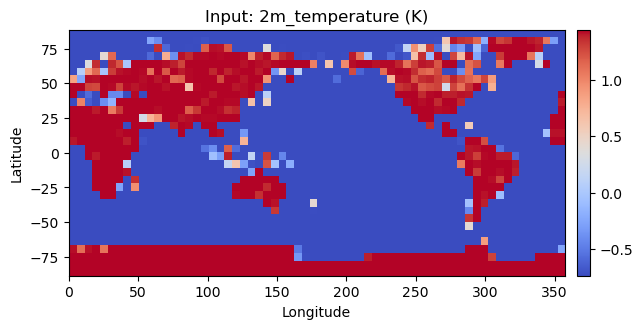

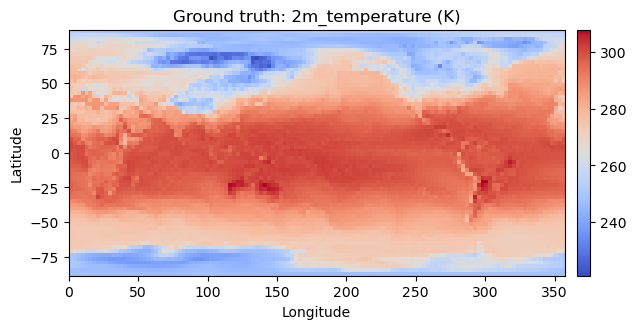

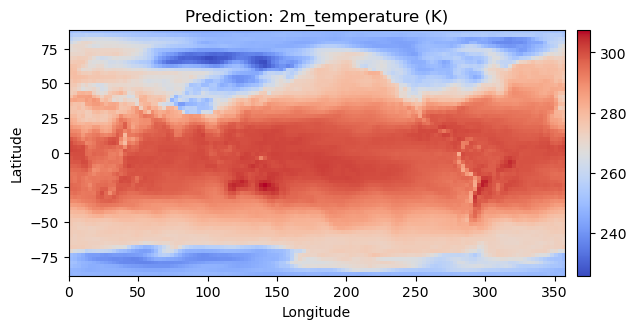

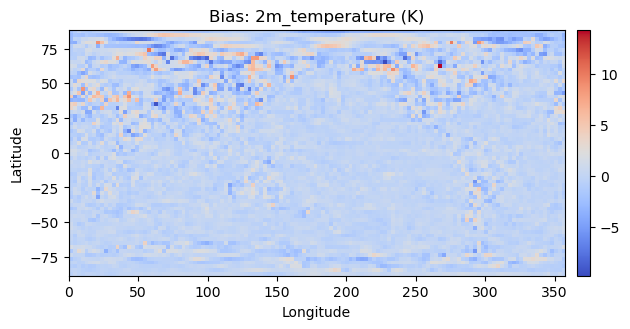

In [5]:
denorm = model.test_target_transforms[0]
in_graphic = visualize_at_index(
    model.to(device="cuda:1"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(49), torch.ones(49)),
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)